In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.52,
    amplitude=3.24e-13 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.520e+00   nan                nan nan  False
amplitude 3.240e-13   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 27184 
    Total predicted counts          : 27131.05
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.72

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.13 s, sys: 24.2 ms, total: 2.16 s
Wall time: 2.18 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 26946 
    Total predicted counts          : 27157.65
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.83

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 26880 
    Total predicted counts          : 27178.45
    Total off counts                : 101764.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_26 

    Total counts                    : 27272 
    Total predicted counts          : 27161.45
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_27 

    Total counts                    : 27102 
    Total predicted counts          : 27128.65
    Total off counts                : 101515.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_55 

    Total counts                    : 27126 
    Total predicted counts          : 27151.05
    Total off counts                : 101627.00

    Total background counts         : 20325.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_56 

    Total counts                    : 27175 
    Total predicted counts          : 27214.65
    Total off counts                : 101945.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_84 

    Total counts                    : 26985 
    Total predicted counts          : 27036.25
    Total off counts                : 101053.00

    Total background counts         : 20210.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_85 

    Total counts                    : 27185 
    Total predicted counts          : 27086.05
    Total off counts                : 101302.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_112 

    Total counts                    : 27070 
    Total predicted counts          : 27128.05
    Total off counts                : 101512.00

    Total background counts         : 20302.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_113 

    Total counts                    : 27079 
    Total predicted counts          : 27127.45
    Total off counts                : 101509.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_141 

    Total counts                    : 27102 
    Total predicted counts          : 27140.25
    Total off counts                : 101573.00

    Total background counts         : 20314.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.92

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_142 

    Total counts                    : 27327 
    Total predicted counts          : 26894.85
    Total off counts                : 100346.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 27175 
    Total predicted counts          : 27158.85
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.68

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 27010 
    Total predicted counts          : 26993.85
    Total off counts                : 100841.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 26751 
    Total predicted counts          : 27233.85
    Total off counts                : 102041.00

    Total background counts         : 20408.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_203 

    Total counts                    : 27400 
    Total predicted counts          : 27188.65
    Total off counts                : 101815.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_227 

    Total counts                    : 26880 
    Total predicted counts          : 27125.45
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.55

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 26761 
    Total predicted counts          : 27154.05
    Total off counts                : 101642.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_248 

    Total counts                    : 27089 
    Total predicted counts          : 27192.25
    Total off counts                : 101833.00

    Total background counts         : 20366.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.73

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_249 

    Total counts                    : 27193 
    Total predicted counts          : 27051.05
    Total off counts                : 101127.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_267 

    Total counts                    : 27055 
    Total predicted counts          : 27169.85
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.75

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_268 

    Total counts                    : 27217 
    Total predicted counts          : 27199.25
    Total off counts                : 101868.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_292 

    Total counts                    : 27197 
    Total predicted counts          : 27140.65
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.96

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_293 

    Total counts                    : 27289 
    Total predicted counts          : 27224.65
    Total off counts                : 101995.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_312 

    Total counts                    : 27008 
    Total predicted counts          : 27248.25
    Total off counts                : 102113.00

    Total background counts         : 20422.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_313 

    Total counts                    : 27229 
    Total predicted counts          : 27105.05
    Total off counts                : 101397.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_338 

    Total counts                    : 27219 
    Total predicted counts          : 27206.45
    Total off counts                : 101904.00

    Total background counts         : 20380.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.44

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_339 

    Total counts                    : 27151 
    Total predicted counts          : 27094.05
    Total off counts                : 101342.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_361 

    Total counts                    : 27156 
    Total predicted counts          : 27138.05
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.77

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_362 

    Total counts                    : 27577 
    Total predicted counts          : 27088.85
    Total off counts                : 101316.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_384 

    Total counts                    : 27379 
    Total predicted counts          : 27073.85
    Total off counts                : 101241.00

    Total background counts         : 20248.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.37

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_385 

    Total counts                    : 27188 
    Total predicted counts          : 27100.85
    Total off counts                : 101376.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 27114 
    Total predicted counts          : 27074.45
    Total off counts                : 101244.00

    Total background counts         : 20248.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.38

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 26966 
    Total predicted counts          : 26972.85
    Total off counts                : 100736.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_427 

    Total counts                    : 26777 
    Total predicted counts          : 27161.65
    Total off counts                : 101680.00

    Total background counts         : 20336.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.00

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_428 

    Total counts                    : 27181 
    Total predicted counts          : 27237.45
    Total off counts                : 102059.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_449 

    Total counts                    : 27319 
    Total predicted counts          : 27120.65
    Total off counts                : 101475.00

    Total background counts         : 20295.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.50

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 27322 
    Total predicted counts          : 27131.85
    Total off counts                : 101531.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 27131 
    Total predicted counts          : 27047.65
    Total off counts                : 101110.00

    Total background counts         : 20222.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.67

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 27029 
    Total predicted counts          : 27277.45
    Total off counts                : 102259.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_491 

    Total counts                    : 27242 
    Total predicted counts          : 27228.05
    Total off counts                : 102012.00

    Total background counts         : 20402.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_492 

    Total counts                    : 26982 
    Total predicted counts          : 27219.25
    Total off counts                : 101968.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

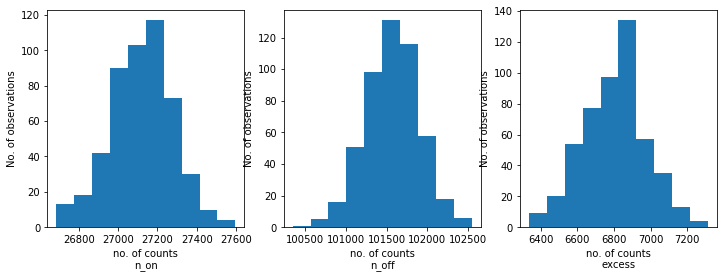

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 55.5 s, sys: 70.4 ms, total: 55.6 s
Wall time: 55.9 s


In [15]:
results

[{'index': 2.4908362649307407, 'amplitude': 3.330633387716075e-13},
 {'index': 2.5139860039209085, 'amplitude': 3.177532839271635e-13},
 {'index': 2.5261520941132485, 'amplitude': 3.0820997647714575e-13},
 {'index': 2.5293412012891556, 'amplitude': 3.1583439060653736e-13},
 {'index': 2.5284559941349674, 'amplitude': 3.1921946054067724e-13},
 {'index': 2.500096053827028, 'amplitude': 3.157349990550987e-13},
 {'index': 2.5407654768761265, 'amplitude': 3.2206623228947836e-13},
 {'index': 2.528406447084641, 'amplitude': 3.144222269972674e-13},
 {'index': 2.5017442909992305, 'amplitude': 3.3142081400208323e-13},
 {'index': 2.50612200089496, 'amplitude': 3.352611242909358e-13},
 {'index': 2.505826944496655, 'amplitude': 3.2684560950460947e-13},
 {'index': 2.51662886025596, 'amplitude': 3.272771236655987e-13},
 {'index': 2.479409430760378, 'amplitude': 3.487347558168554e-13},
 {'index': 2.5367761619014817, 'amplitude': 3.1537877536246704e-13},
 {'index': 2.508842672190637, 'amplitude': 3.4010

index: 2.519430274807128 += 0.015058887117351379


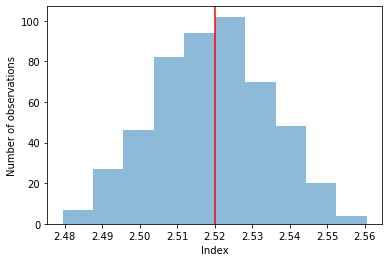

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 3.234931851783184e-13 += 8.979923142869754e-15


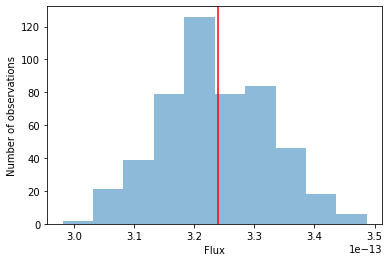

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")